Tianyou Xiao (tx43), Ziyu Song (zs363)

CS 5785 HW 1 Digit Recognizer

In [15]:
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

In [2]:
url_train = 'https://raw.githubusercontent.com/dzuhyoosg/Applied-Machine-Learning/master/homework1/digit-recognizer/train.csv'
url_test = 'https://raw.githubusercontent.com/dzuhyoosg/Applied-Machine-Learning/master/homework1/digit-recognizer/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

In [3]:
# 1(b) display each MNIST digit 0-9
def readData(data):
    return [d for d in data.itertuples(index=False, name=None)]

def showDigits(data):
    digitsSeen, count = [], 0
    for row in data:
        label, digit = row[0], np.array(list(row[1:]))

        if label not in digitsSeen:
            ax = plt.subplot(2, 5, count+1)
            ax.set_title("number: %d" % label)
            plt.imshow(digit.reshape(28, 28))
            digitsSeen.append(label)
            count += 1

        if count == 10:
            break

    plt.savefig("digits.png")

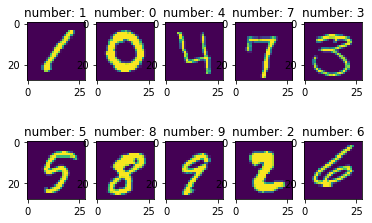

In [4]:
showDigits(readData(train))

In [5]:
train_label = train.iloc[:,0].values
train_image = train.iloc[:,1:].values

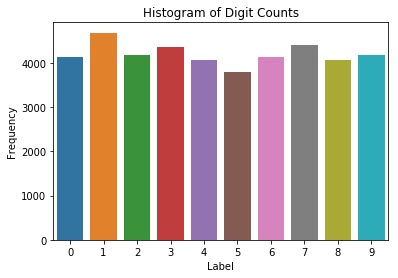

In [6]:
# 1(c) Display a normalized histogram of digit counts
def showDistribution(): 
    sns.countplot(train_label)
    plt.title("Histogram of Digit Counts")
    plt.xlabel("Label")
    plt.ylabel("Frequency")
    return

showDistribution()

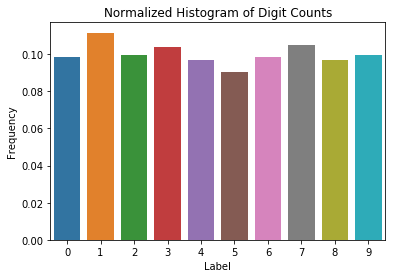

In [7]:
def count_labels(labels):
    res = dict()
    for i in labels:
        res.setdefault(i, 0)
        res[i] += 1

    return res

label_count = count_labels(train_label)


def normalized_dist(data):
    def normalize(d):
        res = []
        for i in range(10):
            res.append(d[i]/len(train_label))
        return res

    sns.barplot([x for x in range(10)], normalize(data))
    plt.title("Normalized Histogram of Digit Counts")
    plt.xlabel("Label")
    plt.ylabel("Frequency")
    return

normalized_dist(label_count)

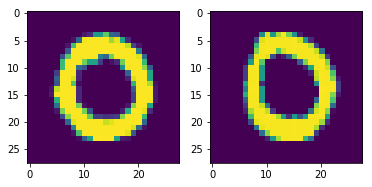

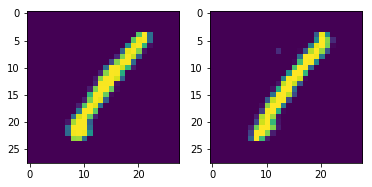

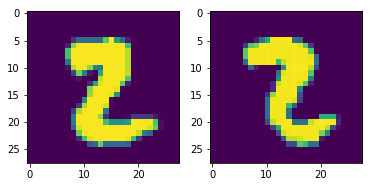

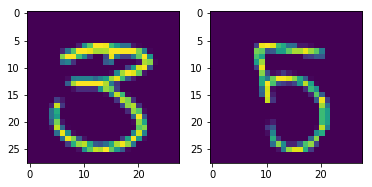

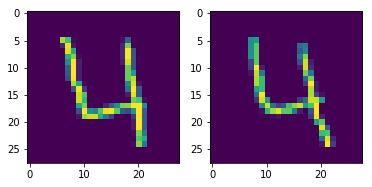

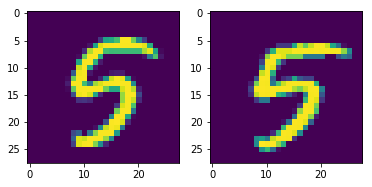

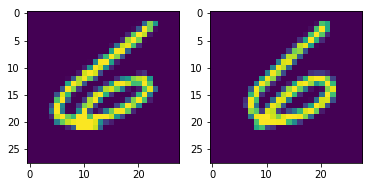

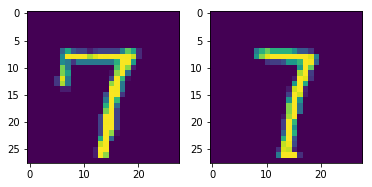

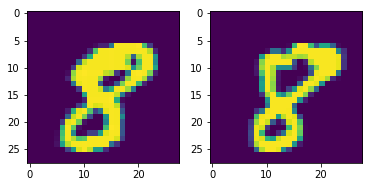

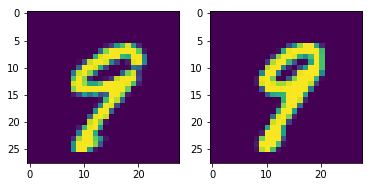

In [8]:
# 1(d) compute and show the best match (nearest neighbor) 
def distance(value1, value2):
    return [(k, np.linalg.norm(value1 - value2[k])) for k in range(len(value2))]

digit_indices = [list(train_label).index(i) for i in range(10)]
dist = []

for i, j in enumerate(digit_indices):
    n = distance(train_image[j], train_image)
    dist.append(sorted(n, key = lambda x: x[1])[1][0])

for n, m in enumerate(dist):
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(train_image[digit_indices[n]].reshape(28,28))
    axs[1].imshow(train_image[m].reshape(28,28))

In [9]:
# 1(e) binary comparison between the digits 0 and 1
indices_01 = [i for i, x in enumerate(train_label) if x == 0 or x == 1]
label_01 = train_label[indices_01]
image_01 = train_image[indices_01]

genuine_distance = []
imposter_distance = []

for index in indices_01:
    label, image = train_label[index], train_image[index]
    match = distance(image, image_01)
    for m in match:
        match_label = label_01[m[0]]
        match_distance = m[1]

        if match_label == label:
            genuine_distance.append(match_distance)
        else:
            imposter_distance.append(match_distance)

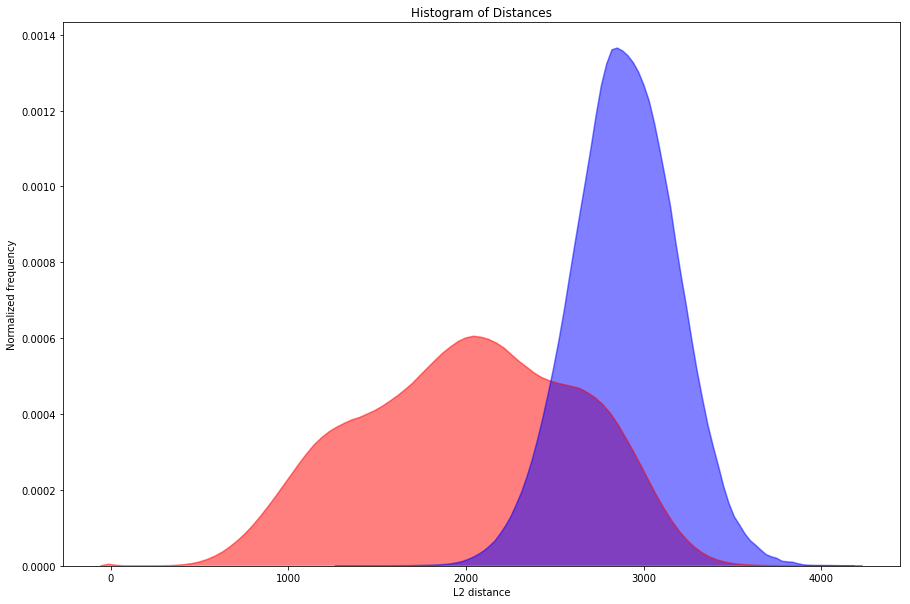

In [10]:
plt.figure(figsize=(15,10))

plt.title('Histogram of Distances')
plt.xlabel('L2 distance')
plt.ylabel('Normalized frequency')

sns.kdeplot(genuine_distance, color='r', shade=True, alpha=.5)
sns.kdeplot(imposter_distance, color='b', shade=True, alpha=.5)

In [60]:
# use the max distance-distance to estimate the probability that the data is geunine match
from sklearn.metrics import roc_curve, auc

y_genuine = [1] * len(genuine_distance)
y_imposter = [0] * len(imposter_distance)

max_dist = max(imposter_distance)

fpr, tpr, thresholds = roc_curve(y_genuine+y_imposter, list(max_dist-np.array(genuine_distance))
                                 +list(max_dist-np.array(imposter_distance)), pos_label=1)

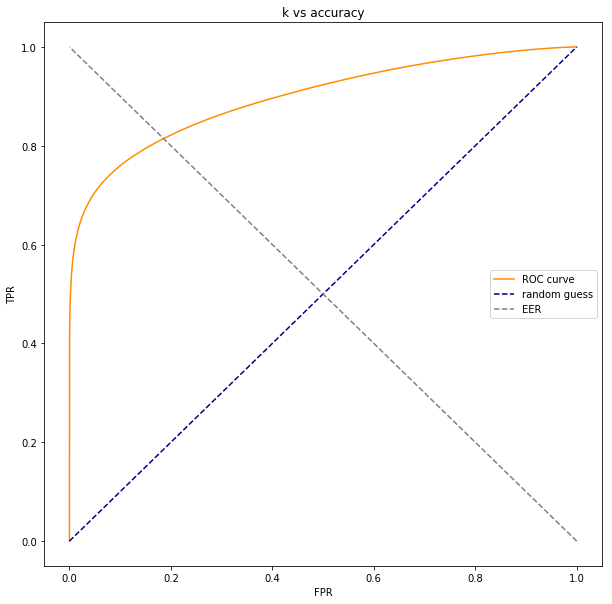

In [62]:
plt.figure(figsize=(10,10))
plt.title('k vs accuracy')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random guess')
plt.plot([1, 0], [0, 1], color='grey', linestyle='--', label='EER')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [65]:
fnr = 1 - tpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('The equal error rate is %f' % EER)

The equal error rate is 0.185548


In [13]:
# implement the KNN
class kNN(object):

    def __init__(self, X_test, k=3):
        self.X_test = X_test
        self.k = k

    def train(self, images, labels):
        self.X_train = images
        self.y_train = labels
    
    def predict_label(self, data, k=3):      
        dist = self.distance(data)
        labels = np.zeros(k, dtype=np.int8)
        for i in range(k):
            labels[i] = self.y_train[dist[i][0]]
        return np.bincount(labels).argmax()

    def distance(self, data):
        tmp = [(k, np.linalg.norm(data - self.X_train[k])) for k in range(len(self.X_train))]
        return sorted(tmp, key = lambda x: x[1])
    
    def predict_all(self, k=3):
        y_preds = np.zeros(len(self.X_test), dtype=np.int8)
        for i in range(len(self.X_test)):
            y_preds[i] = self.predict_label(self.X_test[i], k=k)
        print('Prediction completed.')
        self.y_preds = y_preds
        return y_preds
    
    def acc(self, y_test):
        diff = y_test - self.y_preds
        return len(diff[diff == 0]) / len(y_test)

In [14]:
# split the training and holdout dataset
X_train, X_holdout, y_train, y_holdout = train_test_split(train_image, train_label, test_size=0.15, random_state=42)

In [16]:
# Result from our implementation
start = time.time()
knn = kNN(X_holdout, k=3)
knn.train(X_train, y_train)
y_pred = knn.predict_all()
print('Accuracy: ', knn.acc(y_holdout), ' Time used: %d seconds.' % (time.time()-start))

Prediction completed.
Accuracy:  0.9658730158730159  Time used: 1338 seconds.


In [47]:
# use sklearn's implementation to determine optimal k
k_list = [2,3,5,7,10,20,50]
acc_train = np.zeros(len(k_list))
acc_holdout = np.zeros(len(k_list))

In [48]:
for i in range(len(k_list)):
    start_time = time.time()
    knn_scipy = KNeighborsClassifier(n_neighbors=k_list[i])
    knn_scipy.fit(X_train, y_train)
    acc_train[i] = knn_scipy.score(X_train, y_train)
    acc_holdout[i] = knn_scipy.score(X_holdout, y_holdout)
    print('k=%d: finish fitting,' % k_list[i], 'used %f seconds' % (time .time() - start_time))

k=2: finish fitting, used 1507.711639 seconds
k=3: finish fitting, used 1504.941921 seconds
k=5: finish fitting, used 1505.876645 seconds
k=7: finish fitting, used 1506.198183 seconds
k=10: finish fitting, used 1505.915531 seconds
k=20: finish fitting, used 1507.020597 seconds
k=50: finish fitting, used 1509.159533 seconds


In [55]:
# table of k values vs accuracy on train and holdout
acc_table = pd.DataFrame(np.array([acc_train,acc_holdout]))
acc_table.columns = k_list
acc_table

,2,3,5,7,10,20,50
0,0.981961,0.982297,0.978067,0.975014,0.971849,0.962689,0.945630
1,0.962698,0.965873,0.964444,0.963175,0.959683,0.952857,0.939841


([<matplotlib.axis.XTick at 0x7fcdf43a2630>,
 <a list of 7 Text xticklabel objects>)

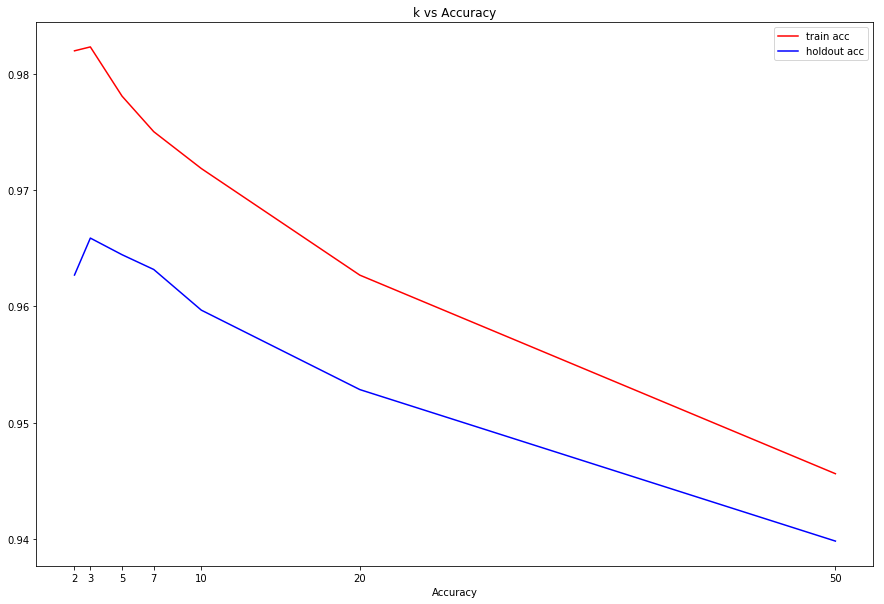

In [49]:
# optimal k=3
plt.figure(figsize=(15,10))
plt.plot(k_list, acc_train, color='r', label='train acc')
plt.plot(k_list, acc_holdout, color='b', label='holdout acc')
plt.xlabel('k')
plt.xlabel('Accuracy')
plt.legend()
plt.title('k vs Accuracy')
plt.xticks(k_list)

In [19]:
# confusion matrix
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_holdout, y_holdout)
y_pred_scipy = model.predict(X_holdout)

cm = confusion_matrix(y_holdout, y_pred_scipy)

In [23]:
df_confusion = pd.DataFrame(cm)
df_confusion

,0,1,2,3,4,5,6,7,8,9
0,599,0,0,0,0,0,1,0,0,0
1,0,679,0,0,1,0,0,0,0,0
2,2,11,615,1,1,0,1,9,5,1
3,1,5,0,703,0,4,0,2,2,2
4,1,7,0,0,612,0,1,1,0,7
5,1,0,0,9,3,497,5,0,0,1
6,4,1,0,0,0,2,591,0,0,0
7,0,15,2,0,3,0,0,638,0,9
8,3,11,3,10,5,5,1,1,572,5
9,2,1,3,9,5,0,0,6,0,603


In [42]:
# Result from our implementation on test dataset
start = time.time()
knn = kNN(test.values, k=3)
knn.train(train_image, train_label)
y_pred_all = knn.predict_all()
print('Time used: %d seconds.' % (time.time()-start))

Prediction completed.
 Time used: 10084 seconds.


In [44]:
# submission for kaggle
submission = pd.DataFrame()
submission['ImageID'] = [i for i in range(1, 28001)]
submission['Label'] = y_pred_all

In [46]:
submission.to_csv('submission.csv', index=False)